## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -1.252423     584.398073   -21.601480     -26.402849   
1            2     -1.252423     584.398073   -21.601480     -26.402849   
2            3     -1.252423     584.398073   -21.601480     -26.402849   
3            4     -1.252423     584.398073   -21.601480     -26.402849   
4            5     -1.252423     584.398073   -21.601480     -26.402849   
...        ...           ...            ...          ...            ...   
1752345     46     -3.068643     528.790329   -15.910643     -20.374965   
1752346     47     -3.068643     528.790329   -15.910643     -20.374965   
1752347     48     -3.068643     528.790329   -15.910643     -20.374965   
1752348     49     -3.068643     528.790329   -15.910643     -20.374965   
1752349     50     -3.068643     528.790329   -15.910643     -20.374965   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 35047
Number of training points: 1051400


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day',
                   'ice', 'snow', 'snowice', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_diff02']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'ice', 'snow', 'snowice',
                   'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(1051400, 45)
(700950, 45)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [20]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)

        m1_pred = heat_diff_model(m1_input)

        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))


        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [21]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [22]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.003853025
RMSE of after m1 0.071828574
RMSE of after m3 0.06753564
RMSE of after m4 0.06700798
RMSE of after m0 0.0043428317
RMSE of after m1 0.04755664
RMSE of after m3 0.045141127
RMSE of after m4 0.04404624
RMSE of after m0 0.0038549202
RMSE of after m1 0.038093902
RMSE of after m3 0.03810053
RMSE of after m4 0.043881986
RMSE of after m0 0.0038721208
RMSE of after m1 0.02290454
RMSE of after m3 0.023300476
RMSE of after m4 0.03740966
RMSE of after m0 0.0045154267
RMSE of after m1 0.021526035
RMSE of after m3 0.023370946
RMSE of after m4 0.02401873
RMSE of after m0 0.0040784394
RMSE of after m1 0.019616349
RMSE of after m3 0.021649642
RMSE of after m4 0.021142518
RMSE of after m0 0.00418453
RMSE of after m1 0.019455064
RMSE of after m3 0.01981716
RMSE of after m4 0.020989781
RMSE of after m0 0.004190685
RMSE of after m1 0.018386738
RMSE of after m3 0.019917307
RMSE of after m4 0.019283574
RMSE of after m0 0.0037297772
RMSE of after m1 0.015779937
RMSE of after m3 0

RMSE of after m0 0.00770787
RMSE of after m1 0.031970482
RMSE of after m3 0.031458292
RMSE of after m4 0.03520294
RMSE of after m0 0.00443374
RMSE of after m1 0.021185558
RMSE of after m3 0.019228736
RMSE of after m4 0.024921749
RMSE of after m0 0.0038537222
RMSE of after m1 0.014732186
RMSE of after m3 0.011768648
RMSE of after m4 0.01921144
RMSE of after m0 0.0039167544
RMSE of after m1 0.017226487
RMSE of after m3 0.014632948
RMSE of after m4 0.021793371
RMSE of after m0 0.0041591795
RMSE of after m1 0.017342707
RMSE of after m3 0.016180042
RMSE of after m4 0.021076102
RMSE of after m0 0.0043785176
RMSE of after m1 0.015047736
RMSE of after m3 0.013408391
RMSE of after m4 0.02232916
RMSE of after m0 0.004938
RMSE of after m1 0.018430552
RMSE of after m3 0.016107637
RMSE of after m4 0.02302637
RMSE of after m0 0.004770471
RMSE of after m1 0.018276583
RMSE of after m3 0.017523516
RMSE of after m4 0.024010487
RMSE of after m0 0.013466309
RMSE of after m1 0.055894874
RMSE of after m3 0.

RMSE of after m0 0.0030179622
RMSE of after m1 0.025111867
RMSE of after m3 0.023106972
RMSE of after m4 0.021418573
RMSE of after m0 0.003970666
RMSE of after m1 0.016107375
RMSE of after m3 0.02127767
RMSE of after m4 0.019832676
RMSE of after m0 0.0051034386
RMSE of after m1 0.023443032
RMSE of after m3 0.027074764
RMSE of after m4 0.025879709
RMSE of after m0 0.006535067
RMSE of after m1 0.02244711
RMSE of after m3 0.023656163
RMSE of after m4 0.022678541
RMSE of after m0 0.006226757
RMSE of after m1 0.014958413
RMSE of after m3 0.020116504
RMSE of after m4 0.019268269
RMSE of after m0 0.0062439176
RMSE of after m1 0.013459812
RMSE of after m3 0.018925842
RMSE of after m4 0.017821867
RMSE of after m0 0.0045698066
RMSE of after m1 0.016715845
RMSE of after m3 0.019783773
RMSE of after m4 0.018725595
RMSE of after m0 0.0060671484
RMSE of after m1 0.057929095
RMSE of after m3 0.055755507
RMSE of after m4 0.054854453
RMSE of after m0 0.005046982
RMSE of after m1 0.051479828
RMSE of aft

RMSE of after m4 0.021285314
RMSE of after m0 0.004504998
RMSE of after m1 0.017593812
RMSE of after m3 0.022525849
RMSE of after m4 0.021274973
RMSE of after m0 0.0065515134
RMSE of after m1 0.045684267
RMSE of after m3 0.04885912
RMSE of after m4 0.046518385
RMSE of after m0 0.005987065
RMSE of after m1 0.027716467
RMSE of after m3 0.037289504
RMSE of after m4 0.036247473
RMSE of after m0 0.005578442
RMSE of after m1 0.018209988
RMSE of after m3 0.03185426
RMSE of after m4 0.030921565
RMSE of after m0 0.005478318
RMSE of after m1 0.027834926
RMSE of after m3 0.035414208
RMSE of after m4 0.034454733
RMSE of after m0 0.0061973445
RMSE of after m1 0.04007428
RMSE of after m3 0.046160195
RMSE of after m4 0.045054488
RMSE of after m0 0.0041743354
RMSE of after m1 0.016363174
RMSE of after m3 0.019680439
RMSE of after m4 0.018427363
RMSE of after m0 0.0049106055
RMSE of after m1 0.013667218
RMSE of after m3 0.019030694
RMSE of after m4 0.017762212
RMSE of after m0 0.004159773
RMSE of after

RMSE of after m0 0.006931587
RMSE of after m1 0.033520438
RMSE of after m3 0.045842487
RMSE of after m4 0.04412029
RMSE of after m0 0.005607974
RMSE of after m1 0.023953512
RMSE of after m3 0.032261197
RMSE of after m4 0.03013275
RMSE of after m0 0.0054953047
RMSE of after m1 0.019006392
RMSE of after m3 0.028384624
RMSE of after m4 0.026168058
RMSE of after m0 0.00481496
RMSE of after m1 0.014245161
RMSE of after m3 0.024984129
RMSE of after m4 0.023442037
RMSE of after m0 0.004446962
RMSE of after m1 0.012772383
RMSE of after m3 0.018483002
RMSE of after m4 0.016507912
RMSE of after m0 0.0046813143
RMSE of after m1 0.012044491
RMSE of after m3 0.018977694
RMSE of after m4 0.016852198
RMSE of after m0 0.0053106165
RMSE of after m1 0.023634192
RMSE of after m3 0.028886152
RMSE of after m4 0.027388373
RMSE of after m0 0.005305991
RMSE of after m1 0.019927973
RMSE of after m3 0.026200697
RMSE of after m4 0.02474097
RMSE of after m0 0.0047899373
RMSE of after m1 0.024027124
RMSE of after 

RMSE of after m0 0.016407976
RMSE of after m1 0.038690533
RMSE of after m3 0.03643004
RMSE of after m4 0.032947406
RMSE of after m0 0.006347692
RMSE of after m1 0.023795217
RMSE of after m3 0.021834344
RMSE of after m4 0.02009689
RMSE of after m0 0.0061908686
RMSE of after m1 0.028222036
RMSE of after m3 0.028152023
RMSE of after m4 0.027336335
RMSE of after m0 0.0036660396
RMSE of after m1 0.058761664
RMSE of after m3 0.057751242
RMSE of after m4 0.057717264
RMSE of after m0 0.0037082925
RMSE of after m1 0.00877606
RMSE of after m3 0.00835154
RMSE of after m4 0.013081182
RMSE of after m0 0.0033502292
RMSE of after m1 0.010807847
RMSE of after m3 0.009474995
RMSE of after m4 0.010203681
RMSE of after m0 0.0030648084
RMSE of after m1 0.012093956
RMSE of after m3 0.010918585
RMSE of after m4 0.009960473
RMSE of after m0 0.0033045618
RMSE of after m1 0.014651494
RMSE of after m3 0.013267355
RMSE of after m4 0.012809052
RMSE of after m0 0.003579006
RMSE of after m1 0.013319757
RMSE of afte

RMSE of after m1 0.012763031
RMSE of after m3 0.010159529
RMSE of after m4 0.019868689
RMSE of after m0 0.003350131
RMSE of after m1 0.010739789
RMSE of after m3 0.0078062895
RMSE of after m4 0.014093526
RMSE of after m0 0.0035418472
RMSE of after m1 0.012563929
RMSE of after m3 0.007895821
RMSE of after m4 0.016243532
RMSE of after m0 0.004625633
RMSE of after m1 0.014259873
RMSE of after m3 0.012232176
RMSE of after m4 0.02327082
RMSE of after m0 0.0059991116
RMSE of after m1 0.010156492
RMSE of after m3 0.009900248
RMSE of after m4 0.031187363
RMSE of after m0 0.008257034
RMSE of after m1 0.007955572
RMSE of after m3 0.010116923
RMSE of after m4 0.038474653
RMSE of after m0 0.00563425
RMSE of after m1 0.010461754
RMSE of after m3 0.012460192
RMSE of after m4 0.028133404
RMSE of after m0 0.004322888
RMSE of after m1 0.0145419855
RMSE of after m3 0.011223423
RMSE of after m4 0.020932948
RMSE of after m0 0.005356243
RMSE of after m1 0.012019568
RMSE of after m3 0.011672428
RMSE of afte

RMSE of after m4 0.03687197
RMSE of after m0 0.006035273
RMSE of after m1 0.02293293
RMSE of after m3 0.020783622
RMSE of after m4 0.023211906
RMSE of after m0 0.0035100346
RMSE of after m1 0.01720992
RMSE of after m3 0.015566611
RMSE of after m4 0.018120619
RMSE of after m0 0.0035667422
RMSE of after m1 0.011562005
RMSE of after m3 0.009362611
RMSE of after m4 0.014853244
RMSE of after m0 0.003897316
RMSE of after m1 0.01115233
RMSE of after m3 0.009829534
RMSE of after m4 0.016364878
RMSE of after m0 0.0046091294
RMSE of after m1 0.01691103
RMSE of after m3 0.016074063
RMSE of after m4 0.022892417
RMSE of after m0 0.0042933878
RMSE of after m1 0.019805359
RMSE of after m3 0.020604704
RMSE of after m4 0.026053114
RMSE of after m0 0.004419318
RMSE of after m1 0.018481938
RMSE of after m3 0.017562408
RMSE of after m4 0.020760754
RMSE of after m0 0.003912119
RMSE of after m1 0.015162173
RMSE of after m3 0.015562069
RMSE of after m4 0.02122806
RMSE of after m0 0.014951756
RMSE of after m1

RMSE of after m0 0.0049483944
RMSE of after m1 0.036338262
RMSE of after m3 0.036277674
RMSE of after m4 0.035094216
RMSE of after m0 0.005234349
RMSE of after m1 0.031381097
RMSE of after m3 0.038010944
RMSE of after m4 0.03652152
RMSE of after m0 0.0066087595
RMSE of after m1 0.041250087
RMSE of after m3 0.052479584
RMSE of after m4 0.051359825
RMSE of after m0 0.004178265
RMSE of after m1 0.027652975
RMSE of after m3 0.02600035
RMSE of after m4 0.024385404
RMSE of after m0 0.008065445
RMSE of after m1 0.01741618
RMSE of after m3 0.02180806
RMSE of after m4 0.020802906
RMSE of after m0 0.004942806
RMSE of after m1 0.01819177
RMSE of after m3 0.020714613
RMSE of after m4 0.019297775
RMSE of after m0 0.0067071863
RMSE of after m1 0.019597126
RMSE of after m3 0.022397224
RMSE of after m4 0.02095269
RMSE of after m0 0.008249688
RMSE of after m1 0.020553984
RMSE of after m3 0.023029711
RMSE of after m4 0.021369496
RMSE of after m0 0.005574266
RMSE of after m1 0.01599361
RMSE of after m3 0

RMSE of after m0 0.004638795
RMSE of after m1 0.013281644
RMSE of after m3 0.021671642
RMSE of after m4 0.019193975
RMSE of after m0 0.0056097466
RMSE of after m1 0.012606406
RMSE of after m3 0.02123328
RMSE of after m4 0.01869252
RMSE of after m0 0.0061283214
RMSE of after m1 0.011877036
RMSE of after m3 0.018890565
RMSE of after m4 0.01599382
RMSE of after m0 0.007990369
RMSE of after m1 0.0442409
RMSE of after m3 0.05033914
RMSE of after m4 0.047544695
RMSE of after m0 0.0075618187
RMSE of after m1 0.03187124
RMSE of after m3 0.04225721
RMSE of after m4 0.041251387
RMSE of after m0 0.006216877
RMSE of after m1 0.025875252
RMSE of after m3 0.036921535
RMSE of after m4 0.035216726
RMSE of after m0 0.00600236
RMSE of after m1 0.03532254
RMSE of after m3 0.042899545
RMSE of after m4 0.041070465
RMSE of after m0 0.0043845437
RMSE of after m1 0.022522887
RMSE of after m3 0.026316516
RMSE of after m4 0.023654029
RMSE of after m0 0.0039453786
RMSE of after m1 0.015675725
RMSE of after m3 0.

RMSE of after m0 0.010912002
RMSE of after m1 0.015767982
RMSE of after m3 0.024541292
RMSE of after m4 0.024745217
RMSE of after m0 0.004094459
RMSE of after m1 0.012930332
RMSE of after m3 0.025980383
RMSE of after m4 0.025370108
RMSE of after m0 0.003982598
RMSE of after m1 0.014625769
RMSE of after m3 0.025292467
RMSE of after m4 0.02392502
RMSE of after m0 0.0040623783
RMSE of after m1 0.016757939
RMSE of after m3 0.025043068
RMSE of after m4 0.024375558
RMSE of after m0 0.0112387
RMSE of after m1 0.028740266
RMSE of after m3 0.033942807
RMSE of after m4 0.033011816
RMSE of after m0 0.0052770744
RMSE of after m1 0.02779009
RMSE of after m3 0.03238561
RMSE of after m4 0.030346101
RMSE of after m0 0.007580114
RMSE of after m1 0.030147493
RMSE of after m3 0.033461545
RMSE of after m4 0.03248818
RMSE of after m0 0.014347942
RMSE of after m1 0.02063971
RMSE of after m3 0.026156435
RMSE of after m4 0.025905283
RMSE of after m0 0.0089332275
RMSE of after m1 0.014219372
RMSE of after m3 0

RMSE of after m1 0.061768323
RMSE of after m3 0.057534914
RMSE of after m4 0.06569577
RMSE of after m0 0.004051815
RMSE of after m1 0.036369693
RMSE of after m3 0.035108436
RMSE of after m4 0.040583648
RMSE of after m0 0.0048579387
RMSE of after m1 0.02576824
RMSE of after m3 0.025975011
RMSE of after m4 0.03215536
RMSE of after m0 0.004207446
RMSE of after m1 0.01897856
RMSE of after m3 0.020737622
RMSE of after m4 0.018451905
RMSE of after m0 0.0041965703
RMSE of after m1 0.016942134
RMSE of after m3 0.018342527
RMSE of after m4 0.01699094
RMSE of after m0 0.0040057334
RMSE of after m1 0.014102308
RMSE of after m3 0.012914472
RMSE of after m4 0.014492198
RMSE of after m0 0.006028152
RMSE of after m1 0.025737837
RMSE of after m3 0.027028946
RMSE of after m4 0.029051032
RMSE of after m0 0.0059508462
RMSE of after m1 0.018728055
RMSE of after m3 0.020908453
RMSE of after m4 0.029364757
RMSE of after m0 0.006598672
RMSE of after m1 0.025881575
RMSE of after m3 0.024735376
RMSE of after m

RMSE of after m0 0.0073013892
RMSE of after m1 0.016673636
RMSE of after m3 0.017247777
RMSE of after m4 0.050382286
RMSE of after m0 0.004325627
RMSE of after m1 0.018832814
RMSE of after m3 0.01689222
RMSE of after m4 0.028198533
RMSE of after m0 0.005127568
RMSE of after m1 0.012855636
RMSE of after m3 0.011657792
RMSE of after m4 0.03571281
RMSE of after m0 0.00419194
RMSE of after m1 0.013451029
RMSE of after m3 0.011299975
RMSE of after m4 0.025542293
RMSE of after m0 0.0040439866
RMSE of after m1 0.024582539
RMSE of after m3 0.028337736
RMSE of after m4 0.029617805
RMSE of after m0 0.010548928
RMSE of after m1 0.044910233
RMSE of after m3 0.041431695
RMSE of after m4 0.07407308
RMSE of after m0 0.012198683
RMSE of after m1 0.036179997
RMSE of after m3 0.03657396
RMSE of after m4 0.085266985
RMSE of after m0 0.0055266223
RMSE of after m1 0.017617157
RMSE of after m3 0.014135611
RMSE of after m4 0.038230173
RMSE of after m0 0.0042914976
RMSE of after m1 0.016406422
RMSE of after m

RMSE of after m0 0.0059702527
RMSE of after m1 0.0147911385
RMSE of after m3 0.014476556
RMSE of after m4 0.017628198
RMSE of after m0 0.00526106
RMSE of after m1 0.016182179
RMSE of after m3 0.015435882
RMSE of after m4 0.017916353
RMSE of after m0 0.004503398
RMSE of after m1 0.0146276085
RMSE of after m3 0.012501666
RMSE of after m4 0.016625678
RMSE of after m0 0.007702286
RMSE of after m1 0.016546862
RMSE of after m3 0.015441117
RMSE of after m4 0.025253333
RMSE of after m0 0.0056201825
RMSE of after m1 0.022483964
RMSE of after m3 0.022028966
RMSE of after m4 0.02518459
RMSE of after m0 0.0042605423
RMSE of after m1 0.011983106
RMSE of after m3 0.010434351
RMSE of after m4 0.013451982
RMSE of after m0 0.004549122
RMSE of after m1 0.015304337
RMSE of after m3 0.0141039705
RMSE of after m4 0.016144926
RMSE of after m0 0.00454353
RMSE of after m1 0.015228135
RMSE of after m3 0.013689528
RMSE of after m4 0.01800835
RMSE of after m0 0.00571175
RMSE of after m1 0.014470909
RMSE of after

Train RMSE Simulated: 0.03670573607087135
Train RMSE Observed Temp: 5.078676700592041
Train L2 Error: 0.004879236686974764
The RMSEs after each modelling stage: [0.00587285 0.02382376 0.         0.025778   0.02958338]


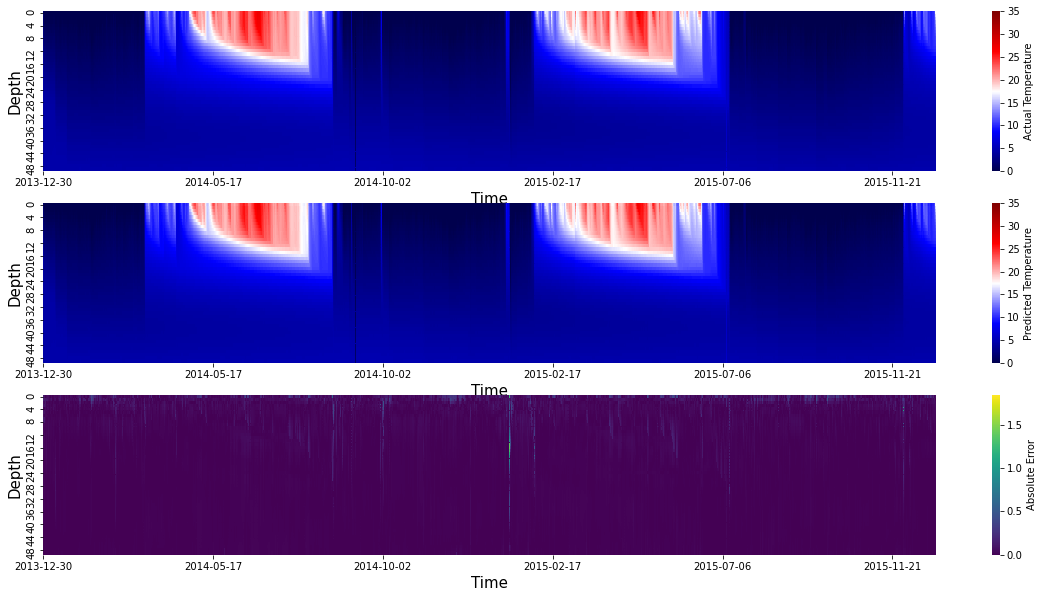

In [23]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

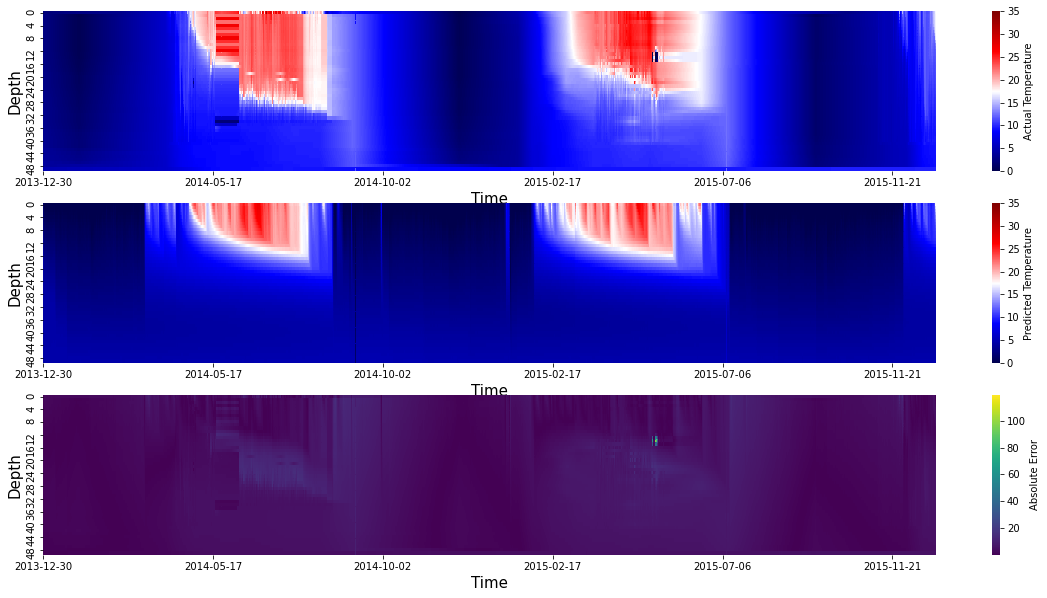

In [24]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [25]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0064778463
RMSE of after m1 0.016045276
RMSE of after m3 0.018873364
RMSE of after m4 0.017833171
RMSE of after m0 0.0074000815
RMSE of after m1 0.050763473
RMSE of after m3 0.04930069
RMSE of after m4 0.048804734
RMSE of after m0 0.004264459
RMSE of after m1 0.021980029
RMSE of after m3 0.030131122
RMSE of after m4 0.02884966
RMSE of after m0 0.0039305994
RMSE of after m1 0.018402668
RMSE of after m3 0.02504229
RMSE of after m4 0.024016408
RMSE of after m0 0.0030312515
RMSE of after m1 0.021066198
RMSE of after m3 0.018430762
RMSE of after m4 0.016742723
RMSE of after m0 0.014599488
RMSE of after m1 0.020680143
RMSE of after m3 0.022633942
RMSE of after m4 0.022411725
RMSE of after m0 0.005361497
RMSE of after m1 0.016452657
RMSE of after m3 0.02131906
RMSE of after m4 0.020786142
RMSE of after m0 0.0044047106
RMSE of after m1 0.01213705
RMSE of after m3 0.018759154
RMSE of after m4 0.017485822
RMSE of after m0 0.0039240248
RMSE of after m1 0.012249944
RMSE of after

RMSE of after m3 0.048080694
RMSE of after m4 0.046548333
RMSE of after m0 0.0035360504
RMSE of after m1 0.013690386
RMSE of after m3 0.020596312
RMSE of after m4 0.018674687
RMSE of after m0 0.0043670763
RMSE of after m1 0.01791595
RMSE of after m3 0.02323631
RMSE of after m4 0.021729916
RMSE of after m0 0.005262812
RMSE of after m1 0.014522181
RMSE of after m3 0.02049048
RMSE of after m4 0.019330403
RMSE of after m0 0.0032444873
RMSE of after m1 0.017779045
RMSE of after m3 0.021308461
RMSE of after m4 0.018915003
RMSE of after m0 0.0038656823
RMSE of after m1 0.01631409
RMSE of after m3 0.021210317
RMSE of after m4 0.019225331
RMSE of after m0 0.0041991887
RMSE of after m1 0.015586381
RMSE of after m3 0.021913007
RMSE of after m4 0.019939931
RMSE of after m0 0.009458734
RMSE of after m1 0.03919739
RMSE of after m3 0.05020016
RMSE of after m4 0.048530795
RMSE of after m0 0.008772227
RMSE of after m1 0.031164426
RMSE of after m3 0.046755936
RMSE of after m4 0.045583714
RMSE of after m

RMSE of after m0 0.0040615294
RMSE of after m1 0.015028094
RMSE of after m3 0.022646748
RMSE of after m4 0.021172257
RMSE of after m0 0.0043956772
RMSE of after m1 0.02025964
RMSE of after m3 0.021050433
RMSE of after m4 0.01966034
RMSE of after m0 0.0047494452
RMSE of after m1 0.017814077
RMSE of after m3 0.02287773
RMSE of after m4 0.021008294
RMSE of after m0 0.007887215
RMSE of after m1 0.053339913
RMSE of after m3 0.05992345
RMSE of after m4 0.05956817
RMSE of after m0 0.008342773
RMSE of after m1 0.05291734
RMSE of after m3 0.064620435
RMSE of after m4 0.06387421
RMSE of after m0 0.0052194023
RMSE of after m1 0.042655405
RMSE of after m3 0.04594901
RMSE of after m4 0.04461091
RMSE of after m0 0.0033769042
RMSE of after m1 0.027652023
RMSE of after m3 0.02386592
RMSE of after m4 0.022520287
RMSE of after m0 0.004662183
RMSE of after m1 0.022765456
RMSE of after m3 0.03280945
RMSE of after m4 0.0315151
RMSE of after m0 0.0052019535
RMSE of after m1 0.015123299
RMSE of after m3 0.02

RMSE of after m4 0.021485934
RMSE of after m0 0.0032887142
RMSE of after m1 0.0153228305
RMSE of after m3 0.015750311
RMSE of after m4 0.020457884
RMSE of after m0 0.0034959812
RMSE of after m1 0.01721296
RMSE of after m3 0.016972579
RMSE of after m4 0.019872205
RMSE of after m0 0.003301672
RMSE of after m1 0.021362657
RMSE of after m3 0.024089942
RMSE of after m4 0.022877516
RMSE of after m0 0.0029741405
RMSE of after m1 0.017421197
RMSE of after m3 0.017861947
RMSE of after m4 0.021568712
RMSE of after m0 0.003277431
RMSE of after m1 0.014936792
RMSE of after m3 0.014717541
RMSE of after m4 0.01876808
RMSE of after m0 0.0039371545
RMSE of after m1 0.021537894
RMSE of after m3 0.026332226
RMSE of after m4 0.027702102
RMSE of after m0 0.0052036773
RMSE of after m1 0.026815172
RMSE of after m3 0.031029182
RMSE of after m4 0.03047746
RMSE of after m0 0.004460006
RMSE of after m1 0.023657193
RMSE of after m3 0.027162679
RMSE of after m4 0.02926273
RMSE of after m0 0.004130165
RMSE of afte

RMSE of after m0 0.0030633064
RMSE of after m1 0.014612442
RMSE of after m3 0.0126485685
RMSE of after m4 0.020922903
RMSE of after m0 0.00640518
RMSE of after m1 0.020228537
RMSE of after m3 0.018991847
RMSE of after m4 0.039424546
RMSE of after m0 0.008650569
RMSE of after m1 0.027458047
RMSE of after m3 0.029506417
RMSE of after m4 0.05559274
RMSE of after m0 0.0056612906
RMSE of after m1 0.012865118
RMSE of after m3 0.011968613
RMSE of after m4 0.042051077
RMSE of after m0 0.0068091885
RMSE of after m1 0.015982239
RMSE of after m3 0.016653191
RMSE of after m4 0.04443949
RMSE of after m0 0.0042067105
RMSE of after m1 0.01199801
RMSE of after m3 0.011546754
RMSE of after m4 0.029840777
RMSE of after m0 0.0046258275
RMSE of after m1 0.02242159
RMSE of after m3 0.024673445
RMSE of after m4 0.027246844
RMSE of after m0 0.004207764
RMSE of after m1 0.014999091
RMSE of after m3 0.013507944
RMSE of after m4 0.019553248
RMSE of after m0 0.0042093433
RMSE of after m1 0.013095934
RMSE of afte

RMSE of after m1 0.028481815
RMSE of after m3 0.02545465
RMSE of after m4 0.026769422
RMSE of after m0 0.009248681
RMSE of after m1 0.0174376
RMSE of after m3 0.015721785
RMSE of after m4 0.018199738
RMSE of after m0 0.00744999
RMSE of after m1 0.028717782
RMSE of after m3 0.02674742
RMSE of after m4 0.025099432
RMSE of after m0 0.008680596
RMSE of after m1 0.020293685
RMSE of after m3 0.018747984
RMSE of after m4 0.019857233
RMSE of after m0 0.010619856
RMSE of after m1 0.021061549
RMSE of after m3 0.0185216
RMSE of after m4 0.02409507
RMSE of after m0 0.010185371
RMSE of after m1 0.020968104
RMSE of after m3 0.018063342
RMSE of after m4 0.02288392
RMSE of after m0 0.01039174
RMSE of after m1 0.02205413
RMSE of after m3 0.019413533
RMSE of after m4 0.02227482
RMSE of after m0 0.010500241
RMSE of after m1 0.016764125
RMSE of after m3 0.017106628
RMSE of after m4 0.016667232
RMSE of after m0 0.009431638
RMSE of after m1 0.018734543
RMSE of after m3 0.01859578
RMSE of after m4 0.01810851

RMSE of after m1 0.013597315
RMSE of after m3 0.017734764
RMSE of after m4 0.016588124
RMSE of after m0 0.0039466606
RMSE of after m1 0.016308801
RMSE of after m3 0.019213626
RMSE of after m4 0.017983934
RMSE of after m0 0.003479034
RMSE of after m1 0.012849126
RMSE of after m3 0.015020078
RMSE of after m4 0.012946324
RMSE of after m0 0.0033668068
RMSE of after m1 0.01317506
RMSE of after m3 0.014802664
RMSE of after m4 0.012673604
RMSE of after m0 0.0035541325
RMSE of after m1 0.0114059895
RMSE of after m3 0.016409617
RMSE of after m4 0.014452573
RMSE of after m0 0.003787395
RMSE of after m1 0.012401418
RMSE of after m3 0.016818337
RMSE of after m4 0.014986133
RMSE of after m0 0.0038280978
RMSE of after m1 0.012920005
RMSE of after m3 0.018290067
RMSE of after m4 0.016582046
RMSE of after m0 0.0041518672
RMSE of after m1 0.012208103
RMSE of after m3 0.016024342
RMSE of after m4 0.014318149
RMSE of after m0 0.004113956
RMSE of after m1 0.0134001495
RMSE of after m3 0.018145015
RMSE of 

RMSE of after m1 0.013413046
RMSE of after m3 0.021339742
RMSE of after m4 0.019261755
RMSE of after m0 0.0053195953
RMSE of after m1 0.024853608
RMSE of after m3 0.035741128
RMSE of after m4 0.034167115
RMSE of after m0 0.0054564537
RMSE of after m1 0.017748222
RMSE of after m3 0.031313546
RMSE of after m4 0.029509094
RMSE of after m0 0.004594445
RMSE of after m1 0.022295458
RMSE of after m3 0.029195327
RMSE of after m4 0.027429909
RMSE of after m0 0.0039048442
RMSE of after m1 0.019313037
RMSE of after m3 0.024152432
RMSE of after m4 0.021316797
RMSE of after m0 0.0050117276
RMSE of after m1 0.019098446
RMSE of after m3 0.02244863
RMSE of after m4 0.021077927
RMSE of after m0 0.0048604077
RMSE of after m1 0.021939754
RMSE of after m3 0.026754841
RMSE of after m4 0.024746913
RMSE of after m0 0.0059995065
RMSE of after m1 0.030700432
RMSE of after m3 0.032013804
RMSE of after m4 0.029720841
RMSE of after m0 0.005983711
RMSE of after m1 0.017346982
RMSE of after m3 0.024831286
RMSE of a

RMSE of after m0 0.0038271213
RMSE of after m1 0.013444088
RMSE of after m3 0.016936027
RMSE of after m4 0.017285308
RMSE of after m0 0.0037274542
RMSE of after m1 0.014809598
RMSE of after m3 0.017379561
RMSE of after m4 0.01767098
RMSE of after m0 0.003240184
RMSE of after m1 0.021703545
RMSE of after m3 0.024565218
RMSE of after m4 0.025411488
RMSE of after m0 0.0041033006
RMSE of after m1 0.16141748
RMSE of after m3 0.1396993
RMSE of after m4 0.13882653
RMSE of after m0 0.006786565
RMSE of after m1 0.12499254
RMSE of after m3 0.11479467
RMSE of after m4 0.11280357
RMSE of after m0 0.010228416
RMSE of after m1 0.06754623
RMSE of after m3 0.06591884
RMSE of after m4 0.06551839
RMSE of after m0 0.008055939
RMSE of after m1 0.029053668
RMSE of after m3 0.031494398
RMSE of after m4 0.03196023
RMSE of after m0 0.010092353
RMSE of after m1 0.022635078
RMSE of after m3 0.0217832
RMSE of after m4 0.0220123
RMSE of after m0 0.01381846
RMSE of after m1 0.06914138
RMSE of after m3 0.07287968
R

KeyboardInterrupt: 

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Finetuning

In [ ]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [ ]:
#freeze_model(heating_model)
freeze_model(heating_model)
unfreeze_model(heat_diff_model)
freeze_model(convection_model)
freeze_model(ice_model)


# Finetuning on Observed Temperature

In [ ]:
heating_model.train()
heat_diff_model.train()
convection_model.train()
ice_model.train()

n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m1_pred = heat_diff_model(m1_input)
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m1_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]},  Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
#plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [ ]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

In [ ]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [ ]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

In [ ]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

In [ ]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Mixing Model

## Convection Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

## Ice Model

In [ ]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

# Compute Model Similarity after Finetuning

In [ ]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [ ]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

In [ ]:
# Freeze all models again and compute finetuned diffusivity values

In [ ]:
# Unfreeze diffusion model and finetune it on projected diffusivities